## Which FPL player position returns the most points?

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.stats import boxcox, zscore, zscore, norm, gaussian_kde

In [13]:
# Current gameweek 
gameweek = 11

# Number of gameweeks to calculate rolling averages off 
rolling_number = 3

## Collect available player data

In [14]:
# Initialize an empty list to store all individual, player gameweek data 
all_player_sep = []

# Loop through each gameweek
for i in range(1, gameweek + 1):  # Adjusting the range to start from 1 to gameweek
    # Read the CSV for the current gameweek
    x = pd.read_csv(rf'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\Players\Seperate_GW\GW_{i}.csv')
    
    # Append the current gameweek data to the list
    all_player_sep.append(x)

# Concatenate all dataframes in the list into a single dataframe
player_data = pd.concat(all_player_sep, axis=0, ignore_index=True)

# Drop unnamed column
player_data = player_data.drop(columns = ['Unnamed: 0'])

In [15]:
# Remove players who play less than 61 minutes in a game (i.e. they do not recieve their 2 points minimum for playoing this amount)
player_data = player_data[player_data['Minutes'] > 60].copy()

## Sample size

In [16]:
# Filter by Goalkeepers, Defenders, Midfielders, and Forwards
final_data_mids = player_data[player_data['Position'] == 'MID'].copy()
final_data_defs = player_data[player_data['Position'] == 'DEF'].copy()
final_data_gks = player_data[player_data['Position'] == 'GK'].copy()
final_data_fwds = player_data[player_data['Position'] == 'FWD'].copy()

## Assess sample size of each category
print(f'GK:',final_data_gks.shape[0])
print(f'DEF:',final_data_defs.shape[0])
print(f'MID:',final_data_mids.shape[0])
print(f'FWD:',final_data_fwds.shape[0])

GK: 219
DEF: 859
MID: 952
FWD: 218


## Average points by position per week

In [17]:
# Create empty list
mean_week_points = []

# Iterate through each unique position and gameweek
positions = player_data['Position'].unique()
gameweeks = player_data['Gameweek'].unique()

for pos in positions:
    for gameweek in gameweeks:
        # Filter data for the specific position and gameweek
        data = player_data[
            (player_data['Position'] == pos) & 
            (player_data['Gameweek'] == gameweek)]
        if not data.empty:
            mean = round(data['GW Points'].mean(), 2)
            s_d = round(data['GW Points'].std(), 2)
        else:
            mean = 0
        mean_week_points.append((gameweek, mean, s_d, pos))

# Create a DataFrame of gameweek average points and deviations by position
mean_week_points_df = pd.DataFrame(mean_week_points, 
        columns=['Gameweek', 'Average Points','Average S.D.', 'Position'])

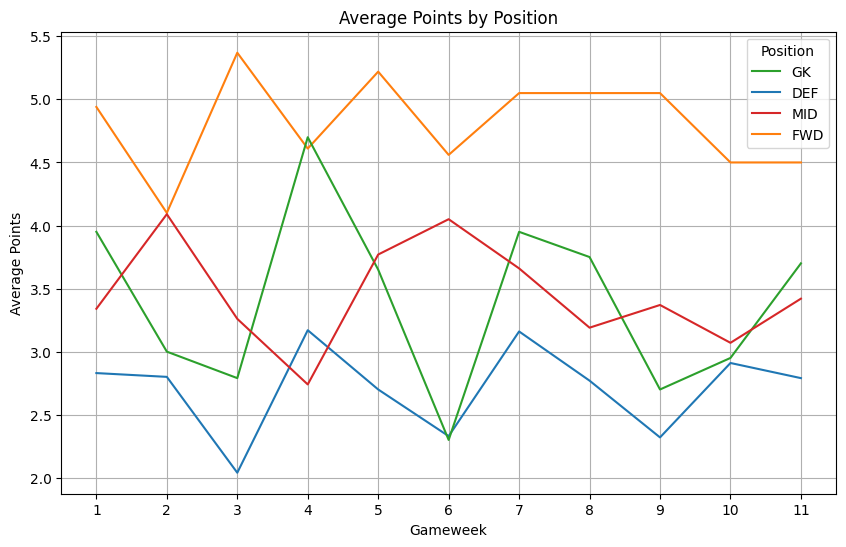

In [18]:
# Create the plot
plt.figure(figsize=(10, 6))
for pos, group_data in mean_week_points_df.groupby('Position'):
    plt.plot(group_data['Gameweek'], group_data['Average Points'], label=pos)

# Sort the legend items in the desired order
desired_order = ['GK','DEF', 'MID', 'FWD']  # Replace with your order
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the handles and labels based on the desired order
ordered_handles = [handles[labels.index(label)] for label in desired_order]
ordered_labels = [label for label in desired_order]

# Add labels and title
plt.xlabel('Gameweek')
plt.xticks(sorted(mean_week_points_df['Gameweek'].unique()))
plt.ylabel('Average Points')
plt.title('Average Points by Position')

# Add the reordered legend
plt.legend(ordered_handles, ordered_labels, title='Position')
plt.grid(True)
plt.show()

In [19]:
# Grouping by 'Position' and summing the 'Mean Points'
position_sum = mean_week_points_df.groupby('Position')[['Average Points','Average S.D.']].mean().sort_values(by = 'Average Points', ascending= False)

# Print
print(position_sum)

          Average Points  Average S.D.
Position                              
FWD             4.813636      3.894545
MID             3.450909      2.980909
GK              3.403636      2.699091
DEF             2.710909      2.686364


It appears that forwards have been scoring higher on average each week than other positions. However, the standard deviation of points scored by forwards is also larger. This essentially says we have less certainty in our decision - a forward may score much lower, or higher, than this. We therefore need to do some more granular analysis. 

## Frequency of point totals

In [20]:
# Calculate frequencies of GW Points for all positions
overall_frequency = (player_data['GW Points']
                     .value_counts()
                     .round(2)
                     .sort_index()
                     .reset_index(name='Total')
                    )
overall_frequency.rename(columns={'index': 'GW Points'}, inplace=True)

# Initialize an empty list to store frequencies for each position
position_frequencies = []

# Get unique positions
positions = player_data['Position'].unique()

# Calculate frequency for each position
for pos in positions:
    # Filter data for the current position
    position_data = player_data[player_data['Position'] == pos]
    
    # Calculate percentage frequency for the position
    pos_frequency = (position_data['GW Points']
                     .value_counts()
                     .mul(100)
                     .round(2) 
                     .sort_index()
                     .reset_index(name=pos)) 
    
    pos_frequency.rename(columns={'index': 'GW Points'}, inplace=True)
    
    # Normalize by overall frequency
    pos_frequency = pos_frequency.merge (overall_frequency, on='GW Points', 
                                         how='left')
    pos_frequency[f'{pos} %'] = ((pos_frequency[pos] / 
                                        pos_frequency['Total']).round(2))
    
    # Append to the list
    position_frequencies.append(pos_frequency[['GW Points', f'{pos} %']])

# Merge all normalized frequencies into a single DataFrame
normalized_data = overall_frequency[['GW Points']]
for freq_df in position_frequencies:
    normalized_data = normalized_data.merge(freq_df, on='GW Points', how='left')

# Fill NaN values with 0
normalized_data.fillna(0, inplace=True)

# Combine data
data = overall_frequency.merge(normalized_data, on = 'GW Points')

# Add counting data
data['DEF_count'] = round(data['Total'] * (data['DEF %']/100), 0).astype(int)
data['MID_count'] = round(data['Total'] * (data['MID %']/100), 0).astype(int)
data['FWD_count'] = round(data['Total'] * (data['FWD %']/100), 0).astype(int)
data['GK_count'] = round(data['Total'] * (data['GK %']/100), 0).astype(int)

data = data[['GW Points', 'Total', 'GK_count', 'DEF_count', 
            'MID_count', 'FWD_count']]

filtered_data = data[data['GW Points'].isin([2,3,8])]

filtered_data = filtered_data.set_index(data.columns[0])

print(data)


    GW Points  Total  GK_count  DEF_count  MID_count  FWD_count
0          -5      1         0          1          0          0
1          -2      4         0          4          0          0
2          -1     11         2          5          4          0
3           0    102         9         90          1          2
4           1    437        30        277        115         15
5           2    874        75        241        457        101
6           3    194        40          5        148          1
7           4     41        13         17          9          2
8           5     90         6         27         45         12
9           6    177        15        104         40         18
10          7     74         3         36         25         10
11          8     69         5         21         25         18
12          9     63        11         16         19         17
13         10     39         4          5         28          2
14         11     21         3          

## Histograms of point frequency by position

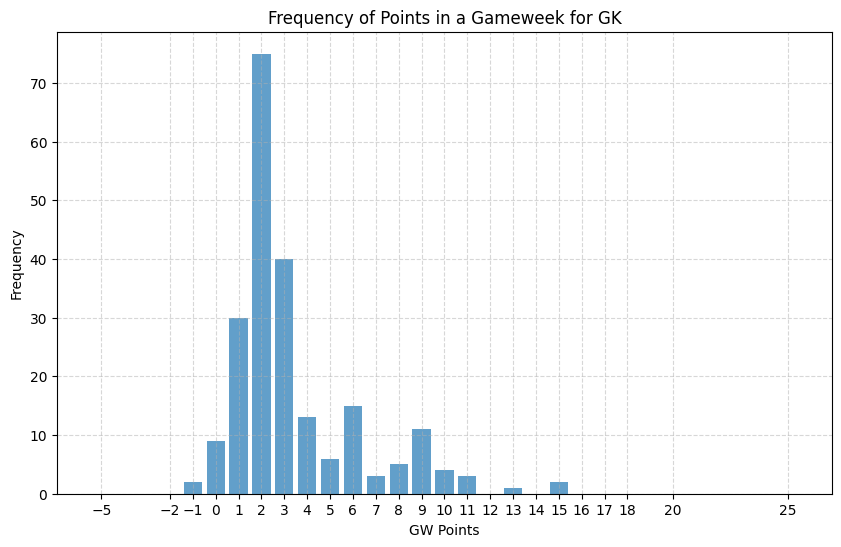

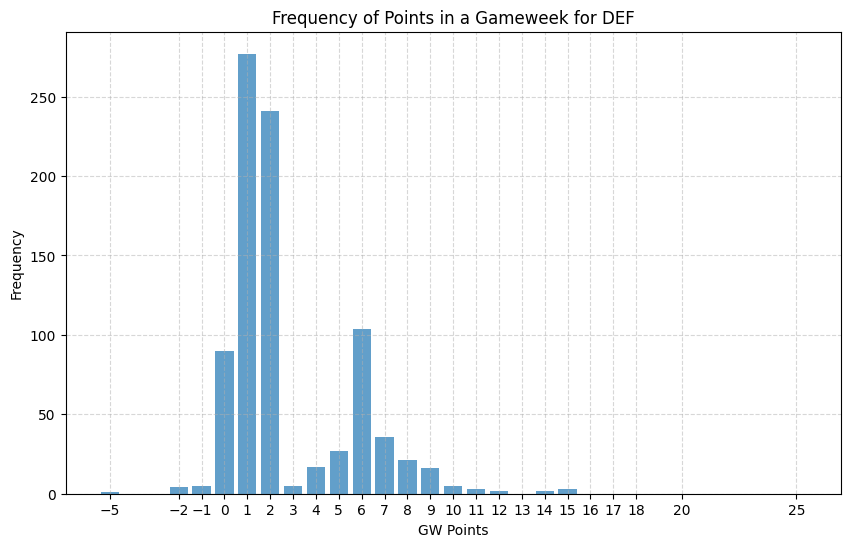

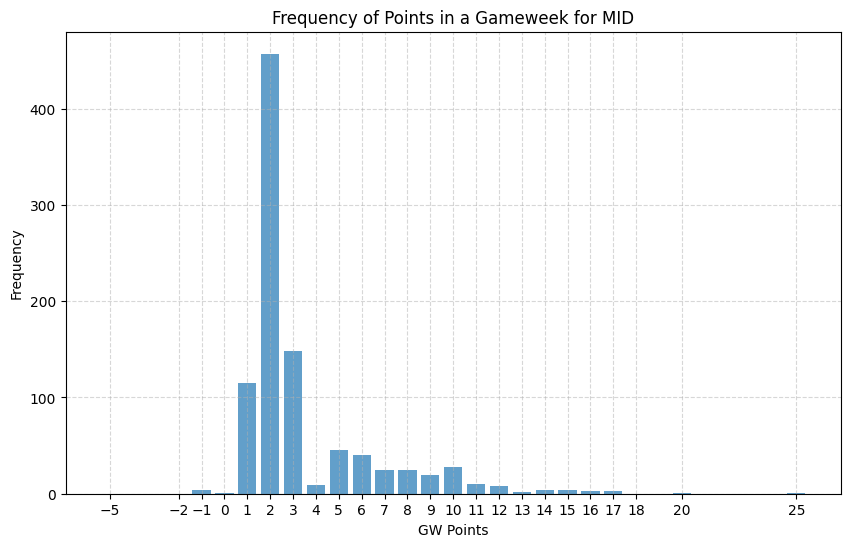

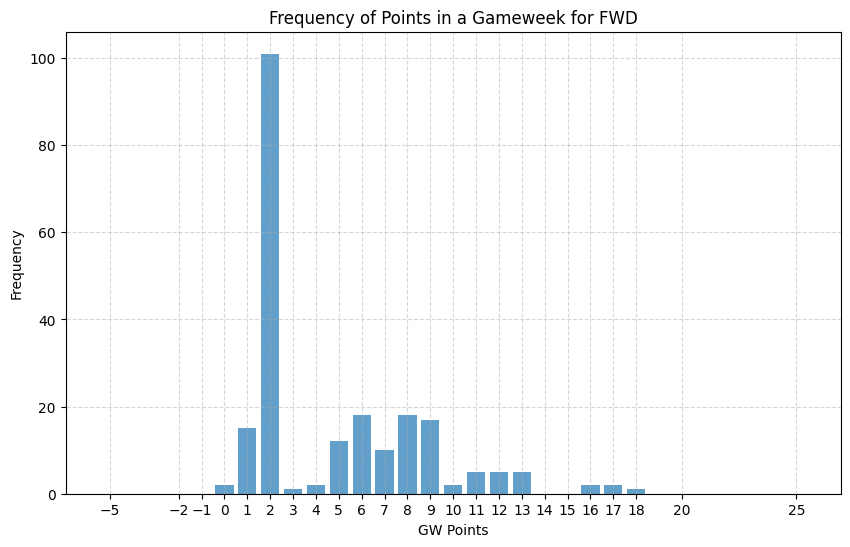

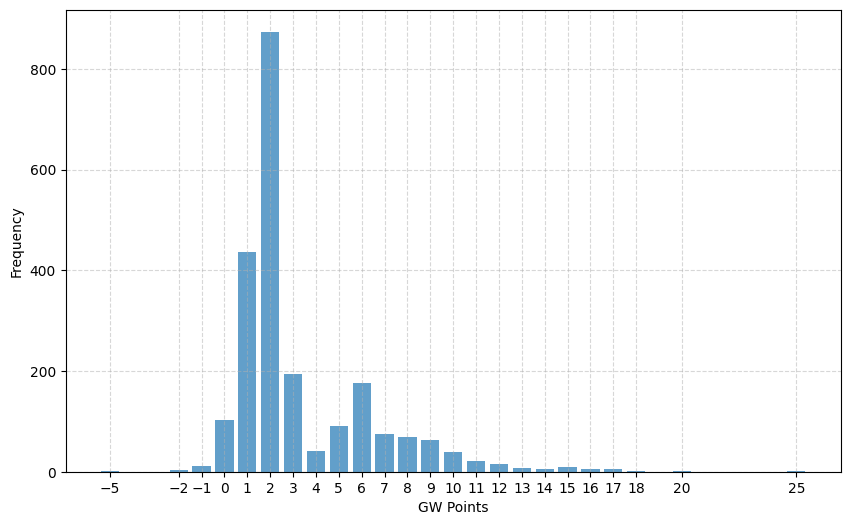

In [21]:
df = pd.DataFrame(data)

# List of columns ending with '_count'
count_columns = [col for col in df.columns if col.endswith('_count')]

# Plotting histograms for each '_count' column
for col in count_columns:
    plt.figure(figsize=(10, 6))
    plt.bar(df['GW Points'], df[col], width=0.8, align='center', alpha=0.7)
    plt.xlabel('GW Points')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Points in a Gameweek for {col[:-6]}')
    plt.xticks(df['GW Points'])  # Ensure all GW Points are shown on the x-axis
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example frequency calculation (ensure this matches your actual data format)
# Assuming player_data['GW Points'] contains individual GW points data
freq_data = player_data['GW Points'].value_counts().sort_index()
x = freq_data.index  # Unique GW points
y = freq_data.values  # Corresponding frequencies

plt.figure(figsize=(10, 6))
plt.bar(x, y, width=0.8, align='center', alpha=0.7)
plt.xlabel('GW Points')
plt.ylabel('Frequency')
plt.xticks(x)  # Ensure all unique GW Points are shown on the x-axis
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## High scoring frequencies

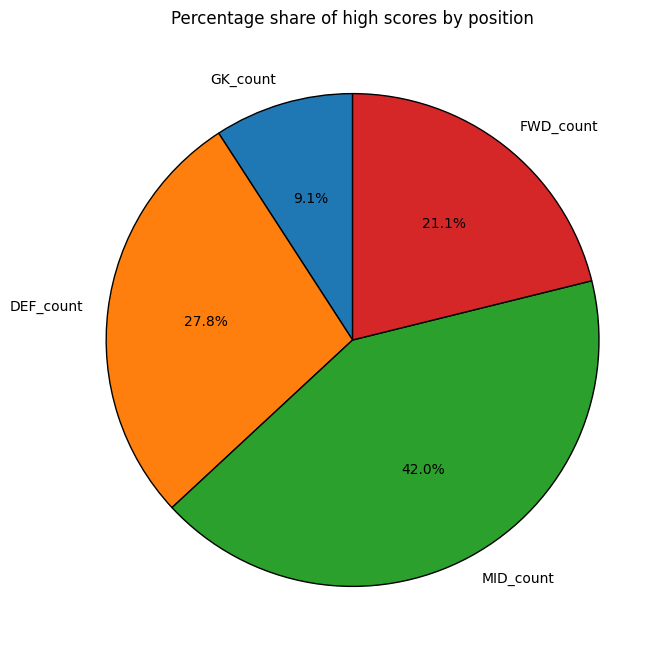

In [22]:
# Filter by high scoring gameweeks
high_data = data[data['GW Points'] > 6]

# Create new dataframe
df = pd.DataFrame(high_data)

# Melt the data for a stacked bar chart
df_melted = df.melt(id_vars=["GW Points"], value_vars=["FWD_count", "MID_count", "DEF_count","GK_count"], 
                    var_name="Position", value_name="Percentage")

# Create the stacked bar chart
fig = px.bar(
    df_melted,
    x="GW Points",
    y="Percentage",
    color="Position",
    title="Frequency of high scores by position",
    labels={"Percentage": "Frequency", "GW Points": "Gameweek Points"},
)

# Customize layout
fig.update_layout(
    barmode="stack",  # Stacked bars
    xaxis=dict(tickmode="linear"),  # Ensure all GW Points are shown
    template="plotly_white"
)

# Show the chart
fig.show()

# Filter and sum specific columns
highest_data = data[data['GW Points'] > 6][['GK_count', 'DEF_count', 'MID_count', 'FWD_count']].sum().values

# Labels and values
labels = ['GK_count', 'DEF_count', 'MID_count', 'FWD_count']
values = highest_data  # Use the ndarray directly for values

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    values, 
    labels=labels, 
    autopct='%1.1f%%',  # Show percentages
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'}
)
plt.title('Percentage share of high scores by position')
plt.show()

Defenders have scored as many high point totals (7+) as forwards, however it is important to remember the sample size of defenders and midfielders is greater than forwards by almost x4. We need to standardize by position sample size. 

## Standardizing

In [23]:
print(filtered_data)
print('\n')

## Assess sample size of each category
print('Position Sample Size\n')
print(f'GK:',final_data_gks.shape[0])
print(f'DEF:',final_data_defs.shape[0])
print(f'MID:',final_data_mids.shape[0])
print(f'FWD:',final_data_fwds.shape[0])

           Total  GK_count  DEF_count  MID_count  FWD_count
GW Points                                                  
2            874        75        241        457        101
3            194        40          5        148          1
8             69         5         21         25         18


Position Sample Size

GK: 219
DEF: 859
MID: 952
FWD: 218


A cross section of this table shows that across the first 11 gameweeks, for players who have played more than 60 minutes in a gameweek, 874 players have scored a total of 2. 457 (52.29%) of these were midfielders and 101 (11.56%) were forwards.

*A proportion of position sample size*, 457 2 point midfielders / total 952 midfielders is approximately 50%. Also, 101 2 point forwards /total 218 forwards is approximately 50%. Therefore, if you were asked to pick either a midfielder or a forward at random for next gameweek, they would each return 2 points 50% of the time. 

Another example is that 194 players have scored a gameweek total of 3. 148 (75%) of these were midfielders, but only 1 (0.52%) was a forward. 

As a proportion of sample size, this represents 148/952 (15%) of midfielders and 1/202 (< .01%) of forwards. So, you could bet someone that they can not pick a forward that will score 3 points in a gameweek - and you'd be right almost everytime. 

Finally 69 players have scored a gameweek total of 8. 25 of these are midfielders and 18 of these are forwards. As a proportion of sample size, though, this reflects only, 25/952 (2.6%) midfielders and 18/202 (8.9%) forwards. Picking a forward at random gives you nearly 9% chance of getting 8 points in the gameweek, whereas only 6% for a midfielder. 

## Frequency Distribution (standardized z-scores)

In [24]:
# Calculate overall z-scores
player_data['Pop_Z'] = zscore(player_data['GW Points'])

# Group Z_scores by position
z_scores_groups = player_data.groupby('Position')['Pop_Z'].mean().round(2)

# Z_scores for population
z_score = round(player_data['Pop_Z'].mean(), 0)

# Print mean scores
print(z_scores_groups)
print('\n')
print(f'Population mean: {z_score}')

Position
DEF   -0.19
FWD    0.49
GK     0.04
MID    0.05
Name: Pop_Z, dtype: float64


Population mean: 0.0


A way of clearly seeing the difference in performance between positions, irrespective of their sample size, is to standardize the data. This essentially takes each player score one at a time and compares this to the average player score across all gameweeks and divide by standard difference of player performance across all gameweeks. 

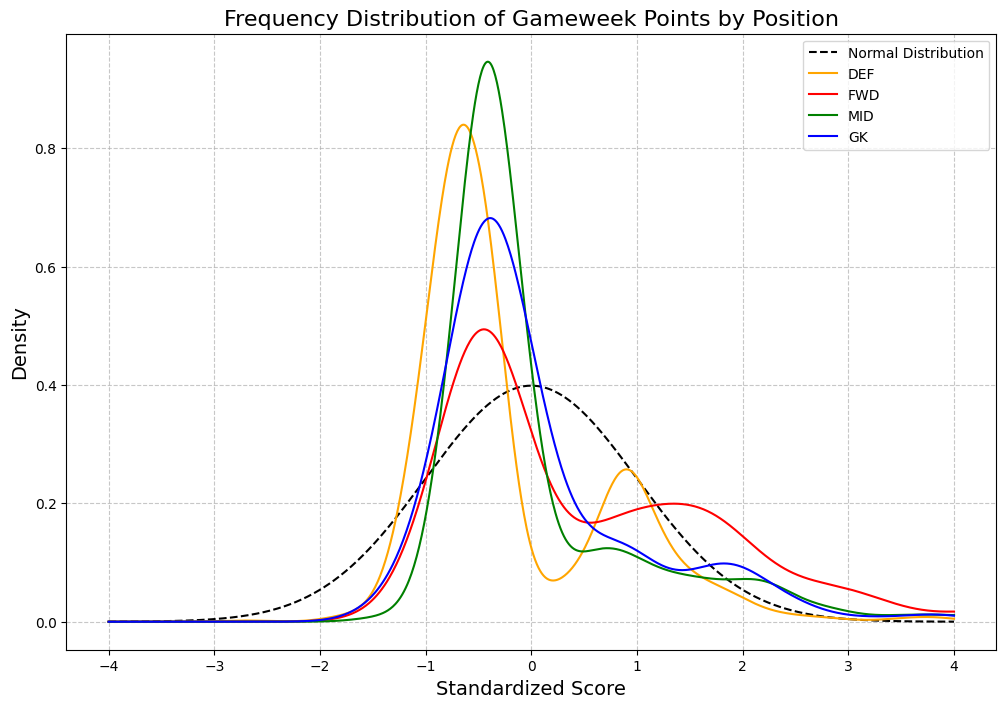

In [25]:
# Sample data setup (for demonstration purposes)
# player_data = your_dataframe_here

x = np.linspace(-4, 4, 1000)  # Range of z-scores (-4 to 4)
y = norm.pdf(x, 0, 1)         # Standard normal distribution

# Plot the overall bell-shaped curve
plt.figure(figsize=(12, 8))
plt.plot(x, y, label='Normal Distribution', color='black', linestyle='--')

# Grouped KDE and scatter points
positions = player_data['Position'].unique()
colors = ['Orange', 'Red', 'Green', 'Blue'] # Generate distinct colors for each position


for position, color in zip(positions, colors):
    group_data = player_data[player_data['Position'] == position]
    z_scores = group_data['Pop_Z']
    
    # KDE curve for each position
    kde = gaussian_kde(z_scores)
    kde_y = kde(x)
    plt.plot(x, kde_y, label=f'{position}', color=color)
    
# Adjust legend to avoid repeating labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)

# Labels and styling
plt.title('Frequency Distribution of Gameweek Points by Position', fontsize=16)
plt.xlabel('Standardized Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


## High scoring probabilities

In [26]:
print(high_data.sum())

GW Points    195
Total        317
GK_count      29
DEF_count     88
MID_count    133
FWD_count     67
dtype: int64


In [27]:
## Assess sample size of each category
print('Position Sample Size\n')
print(f'GK:',final_data_gks.shape[0])
print(f'DEF:',final_data_defs.shape[0])
print(f'MID:',final_data_mids.shape[0])
print(f'FWD:',final_data_fwds.shape[0])

Position Sample Size

GK: 219
DEF: 859
MID: 952
FWD: 218


In summary, the actual probability of scoring 7 or more points from randomly picking a position:

goalkeepers (29/219) = 13.2%
defenders (88/859) = 10.2%
midfielders (133/952) = 13.9%
forwards: (67/218) = 30%

In other words, you have a 90% chance of scoring a minimum 11 points if you pick 3 forwards, who play longer than 60 minutes.

For example, 30% or 30% or 30% = 90% = 7 + 2 + 2 = 11. 
